In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def read_words(file_path):
    with open(file_path, 'r') as file:
        words = set([ word.lower() for word in file.read().splitlines() if word.isalpha() ])
        file.close()
    return list(words)

# read words
words = read_words('../geowords.txt')
print(f'total words: {len(words)}')

total words: 314532


In [4]:
# prepare vocabulary
chars = sorted(list(set(''.join(words))))
stoi = { s:i+1 for i, s in enumerate(chars) }
stoi['.'] = 0
itos = { i:s for s, i in stoi.items() }
vocab_size = len(stoi)
print(f'vocab size: {vocab_size}')
print(f'vocab: {[s for s, _ in stoi.items()]}')

vocab size: 34
vocab: ['ა', 'ბ', 'გ', 'დ', 'ე', 'ვ', 'ზ', 'თ', 'ი', 'კ', 'ლ', 'მ', 'ნ', 'ო', 'პ', 'ჟ', 'რ', 'ს', 'ტ', 'უ', 'ფ', 'ქ', 'ღ', 'ყ', 'შ', 'ჩ', 'ც', 'ძ', 'წ', 'ჭ', 'ხ', 'ჯ', 'ჰ', '.']


In [5]:
import random
random.seed(42069)
random.shuffle(words)

In [6]:
# build dataset of words
block_size = 8
def build_dataset(words_set):
    X, Y = [], []
    for word in words_set:
        context = [0] * block_size
        for ch in word + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
X_train, y_train = build_dataset(words[:n1])
X_dev, y_dev = build_dataset(words[n1:n2])
X_test, y_test = build_dataset(words[n2:])

print(f'---- training set ----')
print(f'input shape: {X_train.shape}')
print(f'label shape: {y_train.shape}')
print(f'total samples: {X_train.shape[0]}')
print(f'---- validation set ----')
print(f'input shape: {X_dev.shape}')
print(f'label shape: {y_dev.shape}')
print(f'total samples: {X_dev.shape[0]}')
print(f'---- testing set ----')
print(f'input shape: {X_test.shape}')
print(f'label shape: {y_test.shape}')
print(f'total samples: {X_test.shape[0]}')

---- training set ----
input shape: torch.Size([2555250, 8])
label shape: torch.Size([2555250])
total samples: 2555250
---- validation set ----
input shape: torch.Size([319854, 8])
label shape: torch.Size([319854])
total samples: 319854
---- testing set ----
input shape: torch.Size([320115, 8])
label shape: torch.Size([320115])
total samples: 320115


In [7]:
for x, y in zip(X_train[:20], y_train[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> ე
.......ე --> ტ
......ეტ --> რ
.....ეტრ --> ა
....ეტრა --> ტ
...ეტრატ --> ზ
..ეტრატზ --> ე
.ეტრატზე --> .
........ --> ა
.......ა --> პ
......აპ --> მ
.....აპმ --> ლ
....აპმლ --> ი
...აპმლი --> ტ
..აპმლიტ --> უ
.აპმლიტუ --> დ
აპმლიტუდ --> ა
პმლიტუდა --> .
........ --> ბ
.......ბ --> ა


In [8]:
class Module:
    def __call__(self, x):
        return self.forward(x)
    def forward(self, x):
        raise NotImplementedError
    def params(self):
        raise NotImplementedError
    
class Linear(Module):
    def __init__(self, fan_in, fan_out, bias=True):
        # batch normalization does not require xavier initialization: fan_in**0.5
        # this initialization works for non-linearities, such as tanh. but won't
        # work for relu or such. if using relu, or other linearities the case
        # of '(fan_in/2)**0.5' will converge and works fine.
        self.weights = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    def forward(self, x):
        self.out = x @ self.weights
        if self.bias is not None: self.out += self.bias
        return self.out
    def params(self):
        return [self.weights] + ([self.bias] if self.bias is not None else [])

class BatchNorm1d(Module):
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # these are the parameters to adjust, tweak
        # and shift normalized data. gamma is a
        # scalar value and beta is a shifter.
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    def forward(self, x):
        # if nn is in training mode we calculate batch
        # mean and variance. else if testing or evaluating
        # we need running mean and variance
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True) #, unbiased=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        # in training mode, we have to update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    def params(self):
        return [self.gamma, self.beta]

class Tanh(Module):
    def forward(self, x):
        self.out = torch.tanh(x)
        return self.out
    def params(self):
        return []

class Embedding(Module):
    def __init__(self, num_embeddings, embedding_dim):
        self.weights = torch.randn((num_embeddings, embedding_dim))
    def __call__(self, IX):
        self.out = self.weights[IX]
        return self.out
    def params(self):
        return [self.weights]

class FlattenConsecutive(Module):
    def __init__(self, n):
        self.n = n
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    def params(self):
        return []

class Sequential(Module):
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def params(self):
        return [p for layer in self.layers for p in layer.params()]

In [31]:
torch.manual_seed(42069)

In [9]:
# preparing neural network
n_embd = 10
n_hidden = 100

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

layers = model.layers

with torch.no_grad():
    layers[-1].weights *= 0.1
    # we should apply gain for other 
    # for layer in layers[:-1]:
    #     if isinstance(layer, Linear):
    #         layer.weights *= 5/3

params = model.params()
print(f"number of parameters: {sum([p.nelement() for p in params])}")
for p in params:
    p.requires_grad = True

number of parameters: 46374


In [10]:
# training phase
max_steps = 400_000
batch_size = 64
lossi = []

for i in range(0, max_steps + 1):
    # batch construct
    ix = torch.randint(0, X_train.shape[0], (batch_size, ))
    X_batch, y_batch = X_train[ix], y_train[ix]
    
    logits = model(X_batch)
    loss = F.cross_entropy(logits, y_batch)

    # backward pass
    # for layer in layers:
    #     layer.out.retain_grad()
    for param in params:
        param.grad = None
    loss.backward()

    # update params
    lr = 0.1 if i < 150_000 else 0.01
    for param in params:
        param.data += -lr * param.grad

    # tracking
    if i % 20_000 == 0:
        print(f'step: {i}; loss: {loss.item():.4f}')
    lossi.append(loss.log10().item())

step: 0; loss: 3.5315
step: 20000; loss: 2.2981
step: 40000; loss: 2.2076
step: 60000; loss: 2.1717
step: 80000; loss: 1.9670
step: 100000; loss: 2.6078
step: 120000; loss: 1.8032
step: 140000; loss: 1.9227
step: 160000; loss: 1.9041
step: 180000; loss: 2.4416
step: 200000; loss: 2.0136
step: 220000; loss: 2.3990
step: 240000; loss: 2.4787
step: 260000; loss: 1.9776
step: 280000; loss: 2.2583
step: 300000; loss: 2.0066
step: 320000; loss: 1.8456
step: 340000; loss: 2.1586
step: 360000; loss: 1.7200
step: 380000; loss: 1.9880
step: 400000; loss: 1.9384


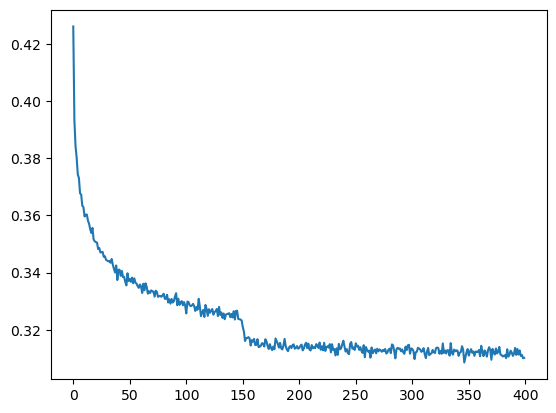

In [11]:
plt.plot(torch.tensor(lossi[:-1]).view(-1, 1000).mean(1))

In [16]:
for layer in model.layers:
    layer.training = False

In [14]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (X_train, y_train),
        'val': (X_dev, y_dev),
        'test': (X_test, y_test),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('test')
split_loss('val')

test 2.047457456588745
val 2.0582492351531982


In [22]:
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

გამოღარსება.
მემმოთექნო.
დაგიფურგულიყისა.
აღსალთ.
უგანივებდეს.
ლიქრინებ.
სენსაგისტმა.
გეპაგურ.
ძლევისთამეებზე.
ხერდისა.
შენაციების.
არაასიათი.
კონეიდაი.
კონპულინი.
მოხრწხათ.
ანგელოიდა.
მაჰერიონებინა.
კოშკრეტის.
გაამართავთა.
შეეფიცნეი.
